Setup
1. Use GPU

Make sure you are using a GPU runtime. Click on runtime -> change runtime type. Under hardware accelerator select GPU and click SAVE.

2. Update fastai

Fastai comes pre-installed in google colab but its an older version. So, we will first update fastai

In [1]:
!pip install fastai --upgrade --quiet


     |████████████████████████████████| 194kB 7.9MB/s 
     |████████████████████████████████| 61kB 5.6MB/s 


In [2]:
from fastai.vision.all import *

**Building state-of-the-art Image classifier**


**Collecting data**


Lets start by creating a data folder where we will keep all our data.

In [3]:
path=Path('Data')
path.mkdir(exist_ok=True)

For building an image classifier we will need urls of images. Generally, you need 80-150 images per class to train a good model.

There are 3 possible ways of collecting data:

Manually copy pasting image urls - Not recommended.
Use existing datasets.
Use Image URL scaper.


In [4]:
!wget -q https://raw.githubusercontent.com/Ankur-singh/image_scrapper/master/datasets/bear.txt


In [5]:
!wget -q https://raw.githubusercontent.com/Ankur-singh/image_scrapper/master/datasets/horse.txt
!wget -q https://raw.githubusercontent.com/Ankur-singh/image_scrapper/master/datasets/dog.txt

In [6]:
download_images('Data/horse', Path('horse.txt'))

In [7]:
download_images('Data/dog', Path('dog.txt'))
download_images('Data/bear', Path('bear.txt'))

In [8]:
files= get_image_files(path)
len(files)

386

180*3 = 540images should be there. but there some extensions which can be rendered from browser but not from python eg : webpi is only rendered and tehier extensions not counted so they easily removed

#verify images


In [9]:
files
#it is list, every element pointing to an images

(#386) [Path('Data/bear/00000149.JPG'),Path('Data/bear/00000003.jpg'),Path('Data/bear/00000179.jpg'),Path('Data/bear/00000026.jpg'),Path('Data/bear/00000018.jpg'),Path('Data/bear/00000144.jpg'),Path('Data/bear/00000094.jpg'),Path('Data/bear/00000012.jpg'),Path('Data/bear/00000036.jpg'),Path('Data/bear/00000069.jpg')...]

In [10]:
failed= verify_images(files)
failed

(#6) [Path('Data/bear/00000079.jpg'),Path('Data/bear/00000087.jpg'),Path('Data/horse/00000085.svg'),Path('Data/horse/00000164.jpg'),Path('Data/horse/00000174.jpg'),Path('Data/dog/00000081.jpg')]

verify_images iterates along with all 320+images. try to read image and if it unable to read an images then its corrupted one and it wll add the name to list

In [11]:
#delete the failed images
failed.map(Path.unlink)

(#6) [None,None,None,None,None,None]

In [12]:
files= get_image_files(path)
len(files)

380

DataLoaders
In machine learning, almost all algorithms take the complete dataset while training. But in-case of deep learning, you don't pass the complete data at once.

You divide the data into smaller batches and pass the batches as input to deep learnining model. DataLoaders allows us to train models on huge dataset. It parallely load the data, in batches, while the model is training.

But we don't have to worry about it. The Datablocks API will take care of everything for us.

To turn our downloaded data into a DataLoaders object we need to tell fastai at least four things:

What kinds of data we are working with
How to get the list of items
How to label these items
How to create the validation set
This is how we can create a DataLoaders for the dataset that we just downloaded:

In [13]:
animals = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # x,y
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

Let's look at each of these arguments in turn. First we provide a tuple where we specify what types we want for the independent and dependent variables:

blocks=(ImageBlock, CategoryBlock)
The independent variable is the thing we are using to make predictions from, and the dependent variable is our target. In this case, our independent variables are images, and our dependent variables are the categories (type of animal) for each image.

For this DataLoaders our underlying items will be file paths. We have to tell fastai how to get a list of those files. The get_image_files function takes a path, and returns a list of all of the images in that path (recursively, by default):

get_items=get_image_files
Next, we will randomly split our data into training and validation sets. However, we would like to have the same training/validation split each time we run this notebook, so we fix the random seed (computers don't really know how to create random numbers at all, but simply create lists of numbers that look random; if you provide the same starting point for that list each time—called the seed—then you will get the exact same list each time):

splitter=RandomSplitter(valid_pct=0.2, seed=42)
The independent variable is often referred to as x and the dependent variable is often referred to as y. Here, we are telling fastai what function to call to create the labels in our dataset:

get_y=parent_label
parent_label function simply gets the name of the folder a file is in. Because we put each of our images into folders based on its class, this is going to give us the labels that we need.

Our images are all different sizes, and this is a problem for deep learning: we don't feed the model one image at a time but several of them (what we call a mini-batch). To group them in a big array (usually called a tensor) that is going to go through our model, they all need to be of the same size. So, we need to add a transform which will resize these images to the same size. Item transforms are pieces of code that run on each individual item, whether it be an image, category, or so forth. Here, we'll use RandomResizedCrop with an image size of 224 px, which is fairly standard for image classification, and default aug_transforms:

item_tfms=RandomResizedCrop(224, min_scale=0.5),
batch_tfms=aug_transforms()
This command has given us a DataBlock object. This is like a template for creating a DataLoaders. We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:



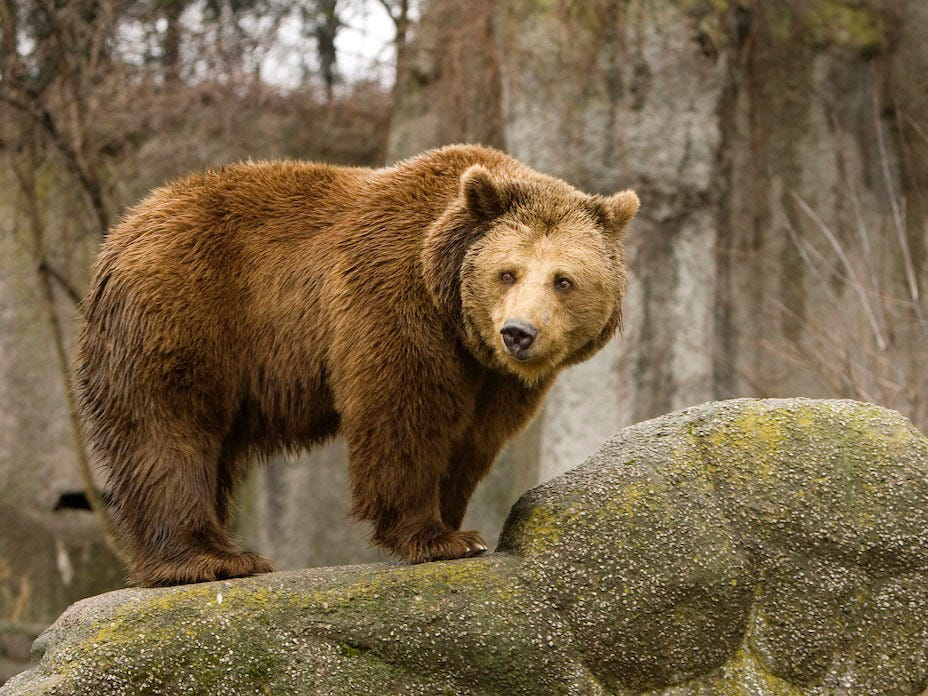

In [14]:
Image.open(files[1])

In [15]:
files[0]

Path('Data/bear/00000149.JPG')

In [16]:
str(files[0]).split('/')

['Data', 'bear', '00000149.JPG']

In [17]:
str(files[0]).split('/')[-2]

'bear'

In [18]:
dls = animals.dataloaders(path)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


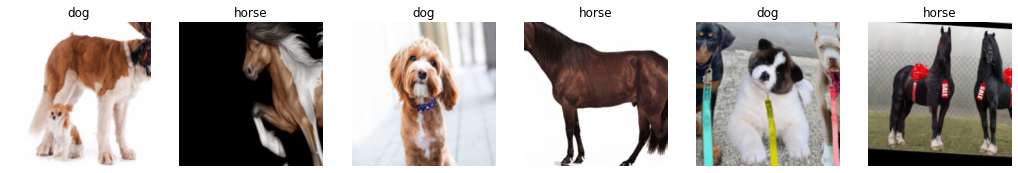

In [19]:
dls.train.show_batch(max_n=6, nrows=1)
#dls.valid.show_batch(max_n=4, nrows=1)

In [20]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.767659,0.377932,0.157895,00:17


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.380456,0.174942,0.065789,00:17
1,0.275877,0.129795,0.039474,00:17
2,0.217683,0.117100,0.052632,00:18


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [21]:
files[10]

Path('Data/bear/00000171.jpg')

In [22]:
learn.predict(files[71])

('horse', tensor(2), tensor([0.3817, 0.0846, 0.5337]))

In [23]:
dls.vocab

['bear', 'dog', 'horse']

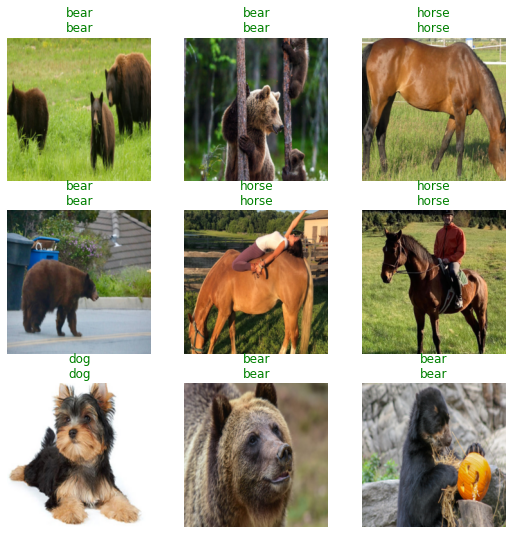

In [24]:
learn.show_results()

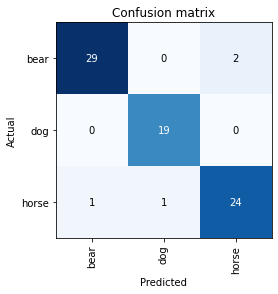

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

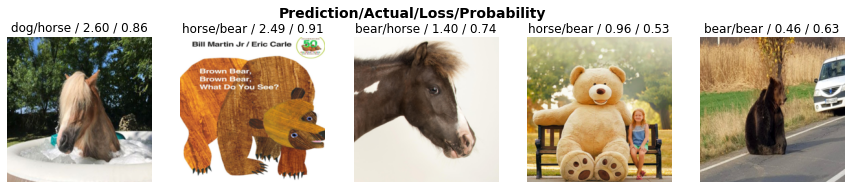

In [26]:

interp.plot_top_losses(5, nrows=1)

Deploying the Model

First, we will export the model that we trained.

In [27]:
learn.export('export.pkl')

In [28]:
!wget -q https://raw.githubusercontent.com/Ankur-singh/CrowdSource-Workshop/main/app.py

In [30]:

!pip install streamlit --quiet
!pip install colab-everything --quiet

     |████████████████████████████████| 7.5MB 6.9MB/s 
     |████████████████████████████████| 163kB 61.6MB/s 
     |████████████████████████████████| 4.5MB 62.1MB/s 
     |████████████████████████████████| 81kB 12.8MB/s 
     |████████████████████████████████| 112kB 64.0MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
     |████████████████████████████████| 122kB 62.4MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.4.3 which is incompatible.
     |████████████████████████████████| 133kB 7.3MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.4.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [ ]:
from colab_everything import ColabStreamlit
ColabStreamlit('app.py')

Web App can be accessed on: http://af6c1bf86ee2.ngrok.io

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:9999
  External URL: http://35.230.100.182:9999

